# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)

from time import time
import warnings

warnings.filterwarnings("ignore")

# Assignment

## Intro

Now that you have seen a variety of models for regression and classification problems, it is good to step back and weigh the pros and cons of these options.  In the case of classification models, there are at least three things to consider:

1. Is the model good at handling imbalanced classes?
2. Does the model train quickly?
3. Does the model yield interpretable results?

Depending on your dataset and goals, the importance of these considerations will vary from project to project.  Your goal is to review our models to this point and discuss the pros and cons of each.  Two example datasets are offered as a way to offer two very different tasks where interpretability of the model may be of differing importance.

## Deliverables

Your goal is to discuss the pros and cons of Logistic Regression, Decision Trees, KNN, and SVM for the tasks below.  Consider at least the three questions above and list any additional considerations you believe are important to determining the "best" model for the task.  Share your response with your peers on the class discussion board.

# Helper Functions

In [2]:
def make_pipeline(estimator_name: str, kwargs: dict):
    xformer = make_column_transformer(
        (
            OneHotEncoder(drop="if_binary"),
            make_column_selector(dtype_include=object),
        ),
        remainder=StandardScaler(),
        verbose_feature_names_out=False,
    )

    classifier = eval(estimator_name)(**kwargs)
    return Pipeline(
        [
            ("xform", xformer),
            ("classifier", classifier),
        ]
    )

In [3]:
def get_scoring_function_kwargs(metric: str):
    return {"average": "weighted"} if metric in ["precision", "recall", "f1"] else {}

In [4]:
def make_scores_dict(estimator, prefix: str, X: pd.DataFrame, y: pd.Series):
    metrics_list = ["accuracy", "balanced_accuracy", "precision", "recall", "f1"]
    scores_dict = {
        prefix
        + metric: round(
            eval(metric + "_score")(
                y, estimator.predict(X), **get_scoring_function_kwargs(metric)
            )
            * 100.0,
            2,
        )
        for metric in metrics_list
    }
    return scores_dict

In [5]:
def grid_search_meta_function(
    X: pd.DataFrame,
    y: pd.Series,
    estimator_name: str,
    grid_search_params: dict,
    scoring: str,
):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42, stratify=y
    )

    tic = time()
    grid = GridSearchCV(
        estimator=make_pipeline(
            estimator_name=estimator_name,
            kwargs=grid_search_params["kwargs"],
        ),
        param_grid=grid_search_params["param_grid"],
        scoring=scoring,
        cv=5,
    ).fit(X_train, y_train)
    grid_search_time = time() - tic

    train_scores = make_scores_dict(
        estimator=grid.best_estimator_,
        prefix="train_",
        X=X_train,
        y=y_train,
    )

    test_scores = make_scores_dict(
        estimator=grid.best_estimator_,
        prefix="test_",
        X=X_test,
        y=y_test,
    )

    return (
        {
            "model": estimator_name,
            "grid search time": grid_search_time,
        }
        | train_scores
        | test_scores
        | {
            "best params": grid.best_params_,
            "best estimator": grid.best_estimator_,
        }
    )

# Task 1: Predicting Customer Churn

Suppose you are tasked with producing a model to predict customer churn.  Which of your classification models would you use and what are the pros and cons of this model for this task?  Be sure to consider interpretability, imbalanced classes, and the speed of training.

In [6]:
churn = pd.read_csv("./data/telecom_churn.csv")
churn.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
# Dropping state for convenience in the tree plots, made no difference to performance anyway, but did speed up the time to drop it
X1 = churn.drop(columns=["State", "Area code", "Churn"])
y1 = churn["Churn"]

In [8]:
y1.value_counts(normalize=True) * 100.0

Churn
False    85.508551
True     14.491449
Name: proportion, dtype: float64

In [9]:
all_grid_search_params = {
    "KNeighborsClassifier": {
        "kwargs": {},
        "param_grid": {
            "classifier__n_neighbors": range(1, 10),
            "classifier__weights": ["uniform", "distance"],
        },
    },
    "DecisionTreeClassifier": {
        "kwargs": {"random_state": 42},
        "param_grid": {
            "classifier__max_depth": range(1, 10),
            "classifier__criterion": ["gini", "entropy"],
        },
    },
    "LogisticRegression": {
        "kwargs": {},
        "param_grid": {
            "classifier__penalty": ["l1", "l2"],
            "classifier__C": np.logspace(start=-5, stop=5, num=11),
        },
    },
    "SVC": {
        "kwargs": {
            "max_iter": 5000,
        },
        "param_grid": {
            "classifier__kernel": ["linear", "rbf"],
        },
    },
}

# all_grid_search_params

In [10]:
estimators_1_list = [
    grid_search_meta_function(
        X=X1,
        y=y1,
        estimator_name=estimator_name,
        grid_search_params=all_grid_search_params[estimator_name],
        scoring="balanced_accuracy",
    )
    for estimator_name in list(all_grid_search_params.keys())
]

estimators_1_df = pd.DataFrame(estimators_1_list)
estimators_1_df

,model,grid search time,train_accuracy,train_balanced_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,best params,best estimator
0,KNeighborsClassifier,1.711883,100.00,100.00,100.00,100.00,100.00,84.77,64.33,83.29,84.77,83.89,"{'classifier__n_neighbors': 1, 'classifier__we...","(ColumnTransformer(remainder=StandardScaler(),..."
1,DecisionTreeClassifier,2.070317,97.20,91.71,97.18,97.20,97.12,93.65,83.93,93.38,93.65,93.42,"{'classifier__criterion': 'entropy', 'classifi...","(ColumnTransformer(remainder=StandardScaler(),..."
2,LogisticRegression,2.084253,86.03,59.14,83.09,86.03,83.31,86.09,60.64,83.42,86.09,83.79,"{'classifier__C': 100.0, 'classifier__penalty'...","(ColumnTransformer(remainder=StandardScaler(),..."
3,SVC,0.671785,94.24,80.68,94.45,94.24,93.67,90.29,69.62,89.82,90.29,88.78,{'classifier__kernel': 'rbf'},"(ColumnTransformer(remainder=StandardScaler(),..."


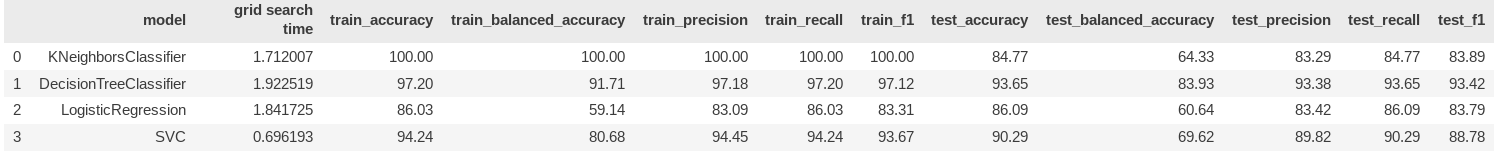

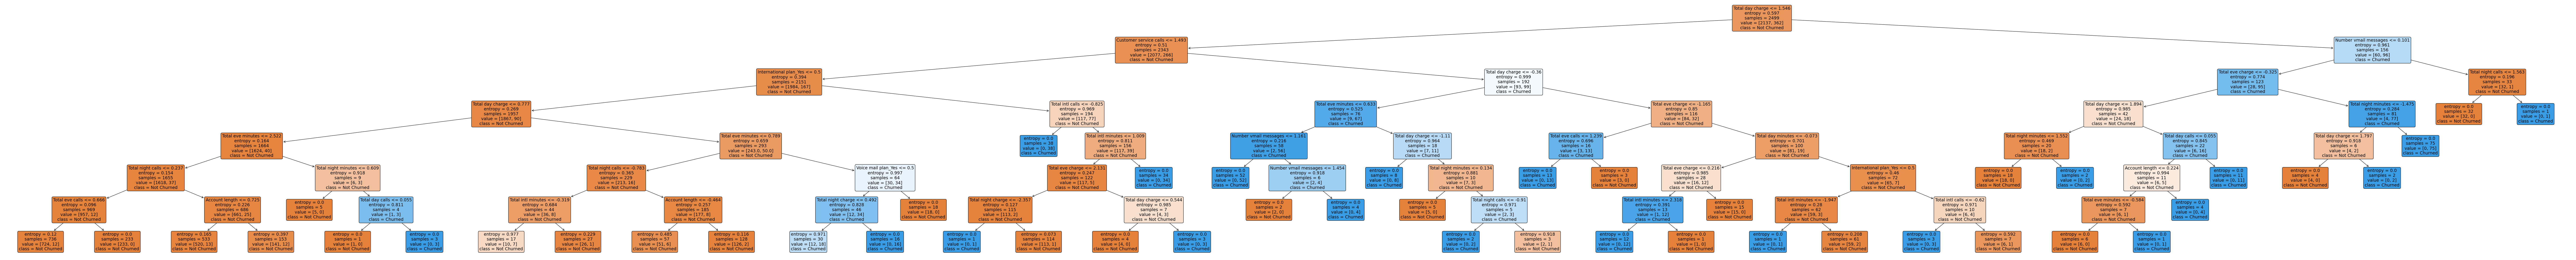

In [19]:
decision_tree = estimators_1_list[1]["best estimator"].named_steps["classifier"]
_, ax = plt.subplots(figsize=(150, 15))
obj = plot_tree(
    decision_tree,
    feature_names=list(
        estimators_1_list[1]["best estimator"]
        .named_steps["xform"]
        .get_feature_names_out()
    ),
    class_names=["Not Churned", "Churned"],
    rounded=True,
    filled=True,
    ax=ax,
)

Try some pruning on the tree

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X1, y1, random_state=42, stratify=y1
)

In [88]:
estimator_name = "DecisionTreeClassifier"
estimator = make_pipeline(
    estimator_name=estimator_name,
    kwargs={"random_state": 42, "criterion": "entropy", "max_depth": 7},
).fit(X_train, y_train)

estimator.score(X_train, y_train)

0.9719887955182073

In [86]:
xformer = estimator.named_steps["xform"]
dtree = estimator.named_steps["classifier"].fit(xformer.fit_transform(X_train), y_train)
dtree.score(xformer.fit_transform(X_test), y_test)

0.9364508393285371

In [99]:
estimator_alpha = make_pipeline(
    estimator_name=estimator_name,
    kwargs={
        "random_state": 42,
        "criterion": "entropy",
        "max_depth": 7,
        "ccp_alpha": path["ccp_alphas"][idx],
    },
).fit(X_train, y_train)

dtree_alpha = estimator_alpha.named_steps["classifier"].fit(
    xformer.fit_transform(X_train), y_train
)
dtree_alpha.score(xformer.fit_transform(X_test), y_test)

0.9280575539568345

In [89]:
path = dtree.cost_complexity_pruning_path(xformer.fit_transform(X_train), y_train)
# path

In [62]:
train_accs = []
test_accs = []
nodes = []

for i in path["ccp_alphas"]:
    dtree = DecisionTreeClassifier(random_state=42, ccp_alpha=i).fit(
        xformer.fit_transform(X_train), y_train
    )
    nodes.append(dtree.tree_.node_count)
    train_accs.append(dtree.score(xformer.fit_transform(X_train), y_train))
    test_accs.append(dtree.score(xformer.fit_transform(X_test), y_test))

Text(0, 0.5, 'Node Count')

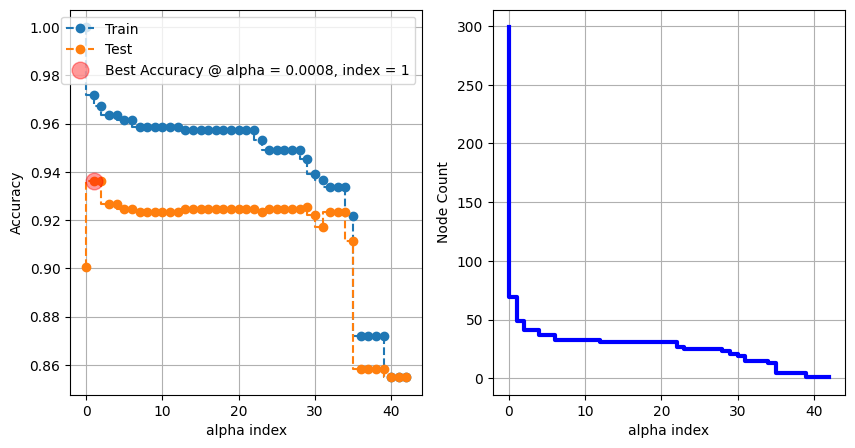

In [80]:
# Answer check
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
idx = [_ for _ in range(len(train_accs))]
ax[0].step(idx, train_accs, "--o", label="Train")
ax[0].step(idx, test_accs, "--o", label="Test")
idx_best_alpha = np.argmax(test_accs)
ax[0].plot(
    idx_best_alpha,
    max(test_accs),
    "ro",
    markersize=12,
    alpha=0.4,
    label="Best Accuracy @ alpha = %.4f, index = %d"
    % (path["ccp_alphas"][idx_best_alpha], idx_best_alpha),
)
ax[0].legend()
ax[0].grid(True)
ax[0].set_xlabel("alpha index")
ax[0].set_ylabel("Accuracy")

ax[1].step(idx, nodes, color="blue", lw=3)
ax[1].grid(True)
ax[1].set_xlabel("alpha index")
ax[1].set_ylabel("Node Count")

In [83]:
for idx, alpha in enumerate(path["ccp_alphas"]):
    print(
        "idx = %02d alpha = %.4f test acc = %.2f node count = %03d"
        % (idx, alpha, test_accs[idx] * 100.0, nodes[idx])
    )

idx = 00 alpha = 0.0000 test acc = 90.05 node count = 299
idx = 01 alpha = 0.0008 test acc = 93.65 node count = 069
idx = 02 alpha = 0.0013 test acc = 93.65 node count = 049
idx = 03 alpha = 0.0016 test acc = 92.69 node count = 041
idx = 04 alpha = 0.0017 test acc = 92.69 node count = 041
idx = 05 alpha = 0.0019 test acc = 92.45 node count = 037
idx = 06 alpha = 0.0019 test acc = 92.45 node count = 037
idx = 07 alpha = 0.0020 test acc = 92.33 node count = 033
idx = 08 alpha = 0.0020 test acc = 92.33 node count = 033
idx = 09 alpha = 0.0020 test acc = 92.33 node count = 033
idx = 10 alpha = 0.0022 test acc = 92.33 node count = 033
idx = 11 alpha = 0.0022 test acc = 92.33 node count = 033
idx = 12 alpha = 0.0022 test acc = 92.33 node count = 033
idx = 13 alpha = 0.0024 test acc = 92.45 node count = 031
idx = 14 alpha = 0.0024 test acc = 92.45 node count = 031
idx = 15 alpha = 0.0025 test acc = 92.45 node count = 031
idx = 16 alpha = 0.0026 test acc = 92.45 node count = 031
idx = 17 alpha

# Task 2: Recognizing Handwritten Digits

Suppose you are tasked with training a model to recognize handwritten digits.  Which of your classifier would you use here and why?  Again, be sure to consider the balance of classes, speed of training, and importance of interpretability.

The data is loaded below.  Note that the handwritten digit data is already split into features and target (`digits`, `labels`). 

In [12]:
digits, labels = load_digits(return_X_y=True)

In [13]:
X2 = pd.DataFrame(
    digits, columns=[("pixel_%02d" % (k + 1)) for k in range(digits.shape[1])]
)

y2 = labels

X2

,pixel_01,pixel_02,pixel_03,pixel_04,pixel_05,pixel_06,pixel_07,pixel_08,pixel_09,pixel_10,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,pixel_64
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


In [14]:
pd.Series(y2).value_counts(normalize=True) * 100.0

3    10.183639
1    10.127991
5    10.127991
4    10.072343
6    10.072343
9    10.016694
7     9.961046
0     9.905398
2     9.849750
8     9.682805
Name: proportion, dtype: float64

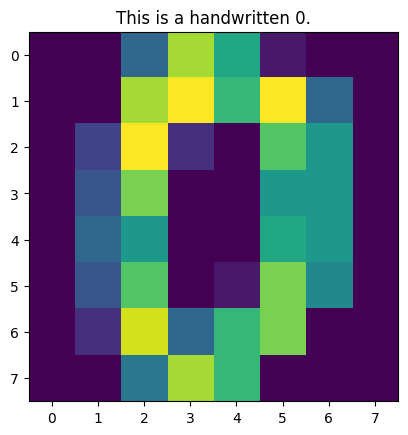

In [15]:
# Example image
plt.imshow(digits[0].reshape(8, 8))
_ = plt.title("This is a handwritten 0.")

In [20]:
estimators_2_list = [
    grid_search_meta_function(
        X=X2,
        y=y2,
        estimator_name=estimator_name,
        grid_search_params=all_grid_search_params[estimator_name],
        scoring="accuracy",
    )
    for estimator_name in list(all_grid_search_params.keys())
]

estimators_2_df = pd.DataFrame(estimators_2_list)
estimators_2_df

,model,grid search time,train_accuracy,train_balanced_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,best params,best estimator
0,KNeighborsClassifier,1.439104,100.00,100.00,100.00,100.00,100.00,96.67,96.63,96.74,96.67,96.65,"{'classifier__n_neighbors': 4, 'classifier__we...","(ColumnTransformer(remainder=StandardScaler(),..."
1,DecisionTreeClassifier,1.491484,99.63,99.62,99.63,99.63,99.63,83.33,83.29,83.79,83.33,83.43,"{'classifier__criterion': 'entropy', 'classifi...","(ColumnTransformer(remainder=StandardScaler(),..."
2,LogisticRegression,1.211365,100.00,100.00,100.00,100.00,100.00,97.78,97.77,97.80,97.78,97.78,"{'classifier__C': 1.0, 'classifier__penalty': ...","(ColumnTransformer(remainder=StandardScaler(),..."
3,SVC,0.358197,99.78,99.78,99.78,99.78,99.78,98.00,97.98,98.03,98.00,98.00,{'classifier__kernel': 'rbf'},"(ColumnTransformer(remainder=StandardScaler(),..."
